In [1]:
import os
import sys
path_to_this_notebook = os.path.abspath('.')
PATH_TO_PROJECT = path_to_this_notebook[: path_to_this_notebook.find('notebooks')]
sys.path.append(PATH_TO_PROJECT)
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices):
    config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-06-26 15:13:36.443294: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-06-26 15:13:37.776830: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-26 15:13:37.777637: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-26 15:13:37.804606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-26 15:13:37.804696: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3070 computeCapability: 8.6
coreClock: 1.83GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-06-26 15:13:37.804710: I tensorflow/stream_executor/platform/def

In [2]:
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import time

from src.metadata_processing.load_data import load_recordings_metadata, load_sounds
from src.metadata_processing.process_sounds_metadata import make_fixed_size_sounds
from src.audiodata_processing.process_waves import process_waves, butter_highpass_filter, denoise_recording
from src.audiodata_processing.extract_features_from_wave import extract_specs, extract_melspecs
from src.deep_learning.splitter.splitter_analysis import *
import tensorflow as tf
from src.util import make_image

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Parameters

In [3]:
# path to metadata
path_to_recordings_metadata = PATH_TO_PROJECT + 'data/'
recordings_metadata_name = 'recordings_metadata.csv'

# Filters should be either 'all' or [val1, val2, ..., ]

colonies = ['arryn']
dates = 'all'
experiments = 'all' # ['single rat softchirps']
stages = 'all' # fresh, split, split and checked, labeled, labeled and checked, traced, traced and check 
classes_to_trace = 'all' # ['sound']

# Specify path to the model
path_to_models = PATH_TO_PROJECT + 'models/splitter/networks/'
path_to_datasets = PATH_TO_PROJECT + 'models/splitter/datasets/'
all_models = os.listdir(path_to_datasets)
print('\n'.join(all_models))

res=2048_step1024_nfft=1024_nmel=80_rec-denoise=False_highpass=3000
res=2048_step1024_nfft=512_nmel=80_rec-denoise=False_highpass=3000
res=2048_step1024_nfft=512_nmel=40_rec-denoise=False_highpass=3000
res=2048_step512_nfft=512_nmel=80_rec-denoise=False_highpass=3000
res=2048_step1024_nfft=1024_nmel=40_rec-denoise=False_highpass=3000
res=1024_step512_nfft=512_nmel=80_rec-denoise=False_highpass=3000
res=1024_step256_nfft=512_nmel=80_rec-denoise=False_highpass=3000


In [4]:
# Choose what model to use
model_name = 'res=2048_step1024_nfft=1024_nmel=80_rec-denoise=False_highpass=3000'
print(model_name)

res=2048_step1024_nfft=1024_nmel=80_rec-denoise=False_highpass=3000


### Loading data

In [5]:
# Load model
model = tf.keras.models.load_model(path_to_models + model_name)
# Load sounds metadata to test the model on and the model params
with open(path_to_datasets + model_name + '/params_dict.pickle', 'rb') as f:
    all_params_dict = pickle.load(f)
recs_to_split, recs_dict = load_recordings_metadata(path_to_recordings_metadata, recordings_metadata_name,
                                                    dates, colonies, experiments, stages)
print(recs_to_split.shape)
recs_to_split.head()

2022-06-26 15:13:41.004568: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-26 15:13:41.005365: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-26 15:13:41.005477: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-26 15:13:41.005563: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3070 computeCapability: 8.6
coreClock: 1.83GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-06-26 15:

Using 88 recordings
(88, 8)


,colony,date,experiment,name,number,path,processing stage,ratids
0,arryn,24-05-19,single rat softchirps,arryn_24-05-19_9624_0000001.npy,1.0,/home/gr1/Projects/naked-mole-rats/data/arryn/...,traced and checked and checked,9624
1,arryn,08-11-19,single rat softchirps,arryn_08-11-19_9435_0000053.npy,53.0,/home/gr1/Projects/naked-mole-rats/data/arryn/...,traced and checked and checked,9435
2,arryn,21-06-19,single rat softchirps,arryn_21-06-19_9435_0000001.npy,1.0,/home/gr1/Projects/naked-mole-rats/data/arryn/...,traced and checked and checked,9435
3,arryn,24-05-19,single rat softchirps,arryn_24-05-19_0827_0000001.npy,1.0,/home/gr1/Projects/naked-mole-rats/data/arryn/...,traced and checked and checked,827
4,arryn,20-04-19,single rat softchirps,arryn_20-04-19_9624_0000001.npy,1.0,/home/gr1/Projects/naked-mole-rats/data/arryn/...,traced and checked and checked,9624


### Splitting

In [6]:
save = False

# Reload data
recs_to_split, recs_dict = load_recordings_metadata(path_to_recordings_metadata, recordings_metadata_name,
                                                    dates, colonies, experiments, stages,
                                                    preloaded_recs_dict=recs_dict)
print('%d recs to split' % (len(recs_to_split)))
# splitting
for rec_name, rec_path in recs_to_split[['name', 'path']].values:
    time_start = time.time()
    rec_ind = np.where(recs_to_split['name'] == rec_name)[0][0]
    rec = np.load(rec_path + rec_name)
    print('\nSplitting recording %s of length %.2f seconds' % (rec_name, len(rec) / all_params_dict['sr']))
    rec_predictions, pred_rec_probs = run_splitter(rec, model, all_params_dict)
    pred_rec_labels, pred_sound_inds = map_prediction_to_sounds(pred_rec_probs, .5, min_length=512)
    df_txt = [(s / all_params_dict['sr'], e / all_params_dict['sr'], 'sound') for s, e in pred_sound_inds]
    df_txt = pd.DataFrame(df_txt, columns=['s', 'e', 'cl'])
    print('Finished!Splitting took %.2f seconds' % (time.time() - time_start))
    if save:
        recs_metadata['processing stage'].iloc[rec_ind] = 'split'
        recs_metadata.to_csv(path_to_recordings_metadata + recordings_metadata_name, index =  None)
        df_txt.to_csv(rec_path + rec_name.replace('npy', 'txt'), index = None, sep = '\t')
    
    else:
        break

Using 88 recordings
88 recs to split

Splitting recording arryn_24-05-19_9624_0000001.npy of length 88.83 seconds


/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_wave.py:60: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_basis = librosa.filters.mel(sr, n_fft=nfft, n_mels=n_mel)
2022-06-26 15:13:46.384760: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-26 15:13:46.403845: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3799900000 Hz
2022-06-26 15:13:46.463252: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-06-26 15:13:46.914706: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-06-26 15:13:46.916420: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-06-26 1

2022-06-26 15:13:50.152775: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:13:50.216505: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:13:50.279661: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:13:50.348137: W tensorflow/stream_executor/gpu/

2022-06-26 15:13:51.931493: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:13:51.993332: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:13:52.059011: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:13:52.120399: W tensorflow/stream_executor/gpu/

2022-06-26 15:13:53.772057: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:13:53.834109: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:13:53.896938: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:13:53.961120: W tensorflow/stream_executor/gpu/

2022-06-26 15:13:55.588789: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:13:55.650513: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:13:55.712440: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:13:55.774677: W tensorflow/stream_executor/gpu/

Finished!Splitting took 10.22 seconds


### Plot results on the last recordings

In [7]:
resolution = all_params_dict['features']['resolution']
step = all_params_dict['features']['step']
sr = all_params_dict['sr']

In [9]:
img = make_image(rec)
predictions_for_each_pixel = resolution / step
px_to_smp = (len(rec) / img.shape[1])
sec_to_px = sr / (len(rec) / img.shape[1])


In [10]:
min_length = 500
rec_labels = np.zeros(len(rec), dtype='int')
for s, e, cl in df_txt.values:
    if cl == 'sound':
        s_rec, e_rec = int(sr * s), int(sr * e)
        rec_labels[s_rec: e_rec] = 1

img_labels = []
for ind in np.arange(0, len(rec) - px_to_smp, px_to_smp):
    pixel_label = np.mean(rec_labels[int(ind): int(ind + px_to_smp)])
    img_labels.append(pixel_label)
img_labels = np.array(img_labels)

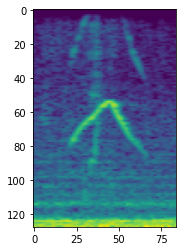

In [15]:
# show random splits
sec_to_px = sr / (len(rec) / img.shape[1])
i = np.random.randint(0, len(df_txt))

s_sec, e_sec = df_txt[['s', 'e']].iloc[i]
s_smp, e_smp = int(sr * s_sec), int(sr * e_sec)
s_px, e_px = int(sec_to_px * s_sec), int(sec_to_px * e_sec)

plt.imshow(img[:, s_px : e_px])

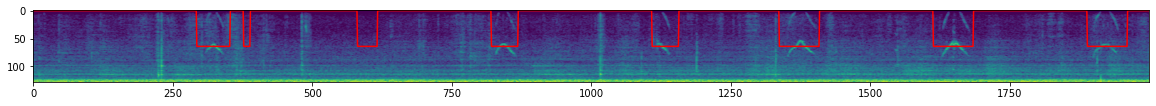

In [17]:
# show random parts of the image with splits
plt.figure(figsize = (20, 20))

start = np.random.randint(0, img.shape[1] - 4000)
end = start + 2000

plt.imshow(img[:, start : end])
plt.plot(64 * (img_labels[start : end] >= .9), c = 'red')